<a href="https://colab.research.google.com/github/aced125/Coulomb_matrix_for_Drug_discovery/blob/master/CoulombNetV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![coulombnet](https://i.ibb.co/zbhw5L7/Coulomb-Net-slides-2.png)

## The Coulomb matrix is defined as:

## $ C_{ij} = \begin{cases}
 \frac{Z_i Z_j}{r_{ij}}, & \text{if } i \neq j \\
 \frac{1}{2}Z_{i}^{2.4}, & \text{if } i = j
\end{cases}$

### where $Z_i$ is the nuclear charge of atom $i$ and $r_{ij}$ is the scalar distance between the 3D coordinaters of atom $i$ and atom $j$.

By encoding a molecule in this sort of representation, we encode **all the information necessary to solve the Schrodinger Equation** for this molecule, from which we can determine **all** properties of the molecule: atomisation energy, dipole moment, you name it...

### Coulomb matrices have been used to successfully construct a map onto atomization energies in the past, which otherwise would be very computationally costly to calculate (using DFT calculations).

### See for example: [Montavan et al 2012](https://pdfs.semanticscholar.org/5761/d22bb67798167a832879a473e0ece867df04.pdf)




![Coulomb_slide_1](https://i.ibb.co/SB1TMy3/Coulomb-Net-slides.png)

## In this notebook we attempt to construct a map from the Coulomb matrix onto the chemical binding of a drug to a particular target.

### We find that the model predicts binding well, about as well as current state of the art models like the Random Forest classifier. 

### More testing shall elucidate whether this type of regressor/classifier can predict binding affinity well of very dissimilar molecules (out-of-domain applicability)

![Coulomb_slide_2](https://i.ibb.co/SNFmL4Z/Coulomb-Net-slides-1.png)

## The process is as follows:

1. Generate the Coulomb matrix for each molecule
2. Convert to a binary input for the neural network
3. Train the neural network

![Coulomb matrix](https://i.ibb.co/ZLyDvFd/Screenshot-2019-08-05-at-12-04-25.png)

Source:  ['Montavon, G 2012, 'Learning Invariant Representations of Molecules for
Atomization Energy Prediction', NIPS](https://pdfs.semanticscholar.org/5761/d22bb67798167a832879a473e0ece867df04.pdf)

## Download RDKit into Google Colab

In [240]:
# Download RDKit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-08-05 14:20:56--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

## Imports

In [241]:
# Append RDKit to system variables
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Clone this repo to get the data (ADR1B strong and weak ligands)
!git clone https://github.com/aced125/RandomMatrixDiscriminant
  
# Imports
import os

# RDkit, a chemoinformatics library
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

# Numpy, a quintessential library
import numpy as np
np.random.seed(42)

# Pandas
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import functools

# Sklearn imports 
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from tqdm import trange

import warnings
warnings.filterwarnings('ignore')

fatal: destination path 'RandomMatrixDiscriminant' already exists and is not an empty directory.


In [0]:
def load_dataset(file_name, drop_non_binders = True):
    '''
    Function to load in the csv dataset from ChEMBL
    '''
    df = pd.read_csv(file_name, encoding = "ISO-8859-1")
    
    # Converting strings to floats, also set all non-numbers to NaN
    df['Standard Vaue'] = pd.to_numeric(df['Standard Value'],errors = 'coerce')

    # Drop Nans in affinity column
    df.dropna(subset = ['Standard Value'], inplace = True)
    df.reset_index(inplace = True)
    df = df.drop('index',axis = 1)
    
    # Filtering for only activities recorded in nanomolar affinity
    df = df[df['Standard Units'] == 'nM']    

    # Dropping any molecules that don't have a SMILES
    df = df.dropna(subset = ['Canonical Smiles'])
    
    # Considering only the binders (compounds with affinities of less than 1000nM)
    if drop_non_binders:
        df = df[df['Standard Value'] < 1000]
    
    # Dropping duplicate molecules
    df = df.drop_duplicates(subset = 'Canonical Smiles', keep = 'first')
    
    return df

In [0]:
df_train_test = load_dataset('/content/RandomMatrixDiscriminant/adr1b_chembl.csv', False)

## The dataframe has the standard value (binding affinity in nM) of the drug, as well as its SMILES string, which we will use to get a view of the molecule, and eventually encode it into its Coulomb matrix

In [243]:
df_train_test[['Standard Value','Canonical Smiles']]

,Standard Value,Canonical Smiles
0,1000.00,CCCCCCCCNC(=O)N1CCc2cc(ccc12)S(=O)(=O)Nc3ccccc3
1,10000.00,COc1ccc(cc1OC)[C@@H](Cc2ccccc2)NC[C@H](O)Cc3cc...
2,6000.00,COc1ccc(cc1)[C@@H](Cc2ccccc2)NC[C@@H](O)Cc3ccc...
3,730.00,COc1ccc(cc1)[C@H](CCc2ccccc2)NC[C@H](O)Cc3ccc(...
4,3981.07,O[C@@H](CNCCNc1cccc(c1)c2sccc2C(=O)O)c3cccc(Cl)c3
5,19.95,C[C@H](CNc1ccc(cc1)c2nc(cs2)C(=O)O)NC[C@H](O)c...
8,111000.00,[Na+].[Na+].C[C@H](Cc1ccc2OC(Oc2c1)(C(=O)[O-])...
9,186.00,CC(C)NCC(O)COc1ccc(C)c2CCCc12
11,310.00,C[C@H](Cc1ccc(OCC(=O)NO)cc1)NC[C@H](O)c2cccc(C...
14,580.00,CCCCCCCCc1onc(n1)N2CCc3cc(ccc23)S(=O)(=O)Nc4cc...


## Select the relevant part of the dataframe, to generate our training and testing data

In [0]:
# Get the SMILES strings
smiles_train_test = df_train_test['Canonical Smiles']
smiles_train_test = smiles_train_test.reset_index()['Canonical Smiles']

# Get their respective binding affinities, the quantity we are
# trying to predict.
affinity_train_test = df_train_test['Standard Value']

## Define functions to generate the Coulomb matrix

In [0]:
from scipy.spatial.distance import cdist
def get_coulomb_matrix(numbers, coords):
    """
    Generates the unsorted Coulomb-matrix, given an array of
    atom atomic numbers, and atom coordinates in space (these
    coordinates must be found through minimization of the
    atomic structure)
    """
    top = np.outer(numbers, numbers).astype(np.float64)
    r = cdist(coords, coords)

    with np.errstate(divide='ignore', invalid='ignore'):
        np.divide(top, r, top)
    np.fill_diagonal(top, 0.5 * np.array(numbers) ** 2.4)
    top[top == np.Infinity] = 0
    top[np.isnan(top)] = 0
    return top

In [0]:
def coulomb_generator(smiles):
    '''
    Given a list of SMILES strings, this function
    will return the Coulomb matrices,
    as well as the indices of the SMILES list of
    molecules that failed to be minimized by MM94 force field
    implemented in RDKit.
    '''
    matrices = []
    failed_indices = []
    max_el = 0
    for idx,smile in enumerate(smiles):
        print(idx)
        mol = Chem.MolFromSmiles(smile)
        mol = Chem.AddHs(mol)
        try:
          Chem.EmbedMolecule(mol)
          AllChem.MMFFOptimizeMolecule(mol)
          conf = mol.GetConformer()
          n_atoms = mol.GetNumAtoms()
          z = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
          xyz = conf.GetPositions()
          m = get_coulomb_matrix(z,xyz)
          
          matrices.append(m)
          max_el = max(max_el, m.max())
          print(max_el)
        except:
          print('failed_idx:',idx)
          failed_indices.append(idx)
    
    max_atoms = max([m[0].shape[0] for m in matrices])
    for index, matrix in enumerate(matrices):
        n_atoms = matrix[0].shape[0]
        m = np.zeros((max_atoms, max_atoms))
        m[:n_atoms, :n_atoms] = matrix
        matrices[index] = m
        
    return matrices, failed_indices

## Generate the Coulomb matrices from the SMILES strings of molecules - one Coulomb matrix per molecule

In [248]:
cmatrices, failed_indices = coulomb_generator(np.array(smiles_train_test))

0
388.0234410266618
1
388.0234410266618
2
388.0234410266618
3
388.0234410266618
4
448.79438598087216
5
448.79438598087216
6
448.79438598087216
7
448.79438598087216
8
448.79438598087216
9
448.79438598087216
10
448.79438598087216
11
448.79438598087216
12
448.79438598087216
13
448.79438598087216
14
448.79438598087216
15
448.79438598087216
16
448.79438598087216
17
448.79438598087216
18
448.79438598087216
19
448.79438598087216
20
448.79438598087216
21
448.79438598087216
22
448.79438598087216
23
448.79438598087216
24
448.79438598087216
25
448.79438598087216
26
448.79438598087216
27
448.79438598087216
28
448.79438598087216
29
448.79438598087216
30
448.79438598087216
31
448.79438598087216
32
448.79438598087216
33
448.79438598087216
34
448.79438598087216
35
448.79438598087216
36
448.79438598087216
37
448.79438598087216
38
448.79438598087216
39
448.79438598087216
40
448.79438598087216
41
448.79438598087216
42
448.79438598087216
43
448.79438598087216
44
448.79438598087216
45
448.79438598087216
46

RDKit ERROR: [14:28:53] UFFTYPER: Unrecognized charge state for atom: 6


361447.54095890425
1035
361447.54095890425
1036
361447.54095890425
1037
361447.54095890425
1038
361447.54095890425
1039
361447.54095890425
1040
361447.54095890425
1041
361447.54095890425
1042
361447.54095890425
1043
361447.54095890425
1044
361447.54095890425
1045
361447.54095890425
1046
361447.54095890425
1047
361447.54095890425
1048
361447.54095890425
1049
361447.54095890425
1050
361447.54095890425
1051
361447.54095890425
1052
361447.54095890425
1053
361447.54095890425
1054
361447.54095890425
1055
361447.54095890425
1056
361447.54095890425
1057
361447.54095890425
1058
361447.54095890425
1059
361447.54095890425
1060
361447.54095890425
1061
361447.54095890425
1062
361447.54095890425
1063
361447.54095890425
1064
361447.54095890425
1065
361447.54095890425
1066
361447.54095890425
1067
361447.54095890425
1068
361447.54095890425
1069
361447.54095890425
1070
361447.54095890425
1071
361447.54095890425
1072
361447.54095890425
1073
361447.54095890425
1074
361447.54095890425
1075
361447.540958904

In [150]:
# Make a copy of the matrix to use in this notebook
cmatrices = np.array(cmatrices)
cmatrices_copy = cmatrices.copy()

NameError: ignored

## Find the indices of datapoints which have a Coulomb element of more than 1000 (probably due to a glitch in the MM94 optimization) and remove these from our dataset. Also, remove datapoints which have binding affinity of 0 (log of 0= -infinity, not good...)

In [0]:
idx_to_remove = np.where(cmatrices_copy > 1000)[0]

In [130]:
idx_to_remove

array([  80,  133,  133,  147,  147,  148,  148,  151,  151,  151,  151,
        156,  188,  252,  265,  265,  284,  300,  393,  393,  401,  401,
        402,  402,  403,  425,  438,  484,  548,  548,  548,  548,  562,
        562,  562,  562,  562,  562,  563,  563,  613,  643,  643,  679,
        679,  680,  680,  707,  716,  789,  861,  862,  894,  894,  894,
        894,  917,  975,  994,  994,  994,  994,  994,  994,  994,  994,
       1074, 1209, 1224, 1257, 1292, 1321, 1323, 1324, 1346, 1347, 1352,
       1392, 1392, 1504, 1512, 1545, 1548, 1548])

In [131]:
## Remove these glitchy datapoints
cmatrices_copy = np.delete(cmatrices_copy, idx_to_remove, axis = 0); cmatrices_copy.shape

(1566, 122, 122)

In [132]:
# Check where our MM94 optimization completely failed
# to even generate a conformer

failed_indices

[559]

In [0]:
# Dropping these failed indices

affinity_train_test = affinity_train_test.drop(affinity_train_test.index[failed_indices])

In [0]:
# Dropping datapoints that had too large Coulomb values

affinity_train_test = affinity_train_test.drop(affinity_train_test.index[idx_to_remove])

In [154]:
affinity_train_test.shape

(1566,)

In [137]:
# Check shape of our data matrix
cmatrices_copy.shape

(1566, 122, 122)

In [157]:
# Checking that there are no 0 values in our
# y_labels series

# Need to remove this value!!

affinity_train_test[affinity_train_test < 0.1]



885     0.000
1831    0.023
2209    0.080
2511    0.040
Name: Standard Value, dtype: float64

In [158]:
# Some (sort of) hacky code to get rid of the weird drug from our dataset
idx_to_drop = np.where(affinity_train_test.index==885)[0]; idx_to_drop
affinity_train_test = affinity_train_test.drop(885)
cmatrices_copy = np.delete(cmatrices_copy, idx_to_drop, axis = 0)
cmatrices_copy.shape

(1565, 122, 122)

In [159]:
affinity_train_test.shape

(1565,)

## Convert binding affinity to the natural logarithm of binding affinity

In [0]:
# We will try to predict the log binding affinity.
# This is more natural to do in the context of drug binding.

log_affinity_train_test = np.log(affinity_train_test)

## Have a look at our final datasets

In [235]:
# X data is cmatrices_copy
# y data is log_affinity_train_test
cmatrices_copy.shape, log_affinity_train_test.shape

((1565, 122, 122), (1565,))

## Let's look at the distribution of log(binding affinities) for the drugs in this dataset

(array([  8.,  10.,  35., 135., 161., 298., 356., 355., 152.,  55.]),
 array([-3.77226106, -2.14933642, -0.52641178,  1.09651286,  2.71943751,
         4.34236215,  5.96528679,  7.58821143,  9.21113608, 10.83406072,
        12.45698536]),
 <a list of 10 Patch objects>)

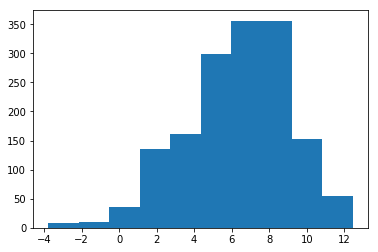

In [161]:
# Let's take a look at our distribution of 
import matplotlib.pyplot as plt
plt.hist(log_affinity_train_test)

## This looks like it's going to be a fairly hard dataset to separate...

## Split the dataset into training and testing sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cmatrices_copy, np.array(log_affinity_train_test), random_state = 101)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [165]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1173, 122, 122), (392, 122, 122), (1173,), (392,))

# Converting the Coulomb matrix into a more suitable input for a neural network

##Three problems with the Coulomb matrix are the follows:
1. The size of the Coulomb matrix is equal to the number of atoms in the molecule. Therefore different molecules will have differently sized Coulomb matrices, which is a less-than-ideal data input.
2.  For one molecule with N atoms, there exists N! possible valid Coulomb matrices, as the molecule is invariant to atom index labelling, but each different set of labels (for which there are N! of them) correspond to a different Coulomb matrix.
3.  A lot of label-relevant information is contained in the ordering

##1.  The first of these issues can be sorted with ***padding***

We take the biggest molecule in our dataset (the one with the most atoms) and simply set the size of all our matrices to that atom. Then, we fill in the matrices of the smaller molecules in the upper left of the big matrix - the rest of the entries are padded with zeros.

![padding_method](https://i.ibb.co/TLTWR1Q/Coulomb-Net-slides-4.png)

##2. The *second* of these issues can be partly negated by sorting the Coulomb matrix essentially by atom weights (in fact, we sort by the row-norm of the matrix, but it's close enough to sorting by atom weights).

## However, there is a catch - when we sort, we add some noise to the matrix, so that the order of each matrix is not exactly the same. This exposes the neural network to slight variations of the Coulomb matrix in each training batch.

![sorting_algo](https://i.ibb.co/zFCLQF9/Screenshot-2019-08-05-at-15-47-39.png)

##3. To work around this problem, we encode the Coulomb matrix at the end into a binary input, the code of which is below. Here is an extract from the original paper for how it is done:

![tanh_input](https://i.ibb.co/K0RwgBC/Screenshot-2019-08-05-at-15-52-00.png)

## Define some input preprocessing functions to tackle the above problems

In [0]:
class Module:
  def update(self, lr):pass
  def average(self,nn,a):pass
  def backward(self,DY):pass
  def forward(self,X):pass

In [0]:
class Input(Module):
  
  def __init__(self,X):
    self.step=1.0
    self.noise=1.0
    
    # Boolean array to select for only the upper triangular half of the matrix.
    # Since the matrix is symmetric, the lower triangular half is exactly the same
    # as the upper triangular half, hence redundant information.
    
    self.triuind = (np.arange(122)[:,np.newaxis] <= np.arange(122)[np.newaxis,:]).flatten()
    
    # Get the maximum value of the X array - this will be required to generate
    # the binary inputs to our neural network
    self.max = 0
    for _ in range(10): 
      self.max=np.maximum(self.max,self.realize(X).max(axis=0))
      
    # Obtain some normalization metrics about the dataset
    X = self.expand(self.realize(X))
    self.nbout = X.shape[1]
    self.mean = X.mean(axis=0)
    self.std = (X - self.mean).std()
    
    
    
    
  def realize(self,X):
    '''
    Function to sort the Coulomb matrix (with some random noise)
    '''
    def _realize_(x):
      inds = np.argsort(-(x**2).sum(axis=0)**.5+np.random.normal(0,self.noise,x[0].shape))
      x = x[inds,:][:,inds]*1
      x = x.flatten()[self.triuind]
      return x
    return np.array([_realize_(z) for z in X])
      
    
  def expand(self,X):
    '''
    Function to expand the Coulomb matrix into a set of (essentially) binary inputs
    '''
    Xexp = []
    for i in range(X.shape[1]):
      for k in np.arange(0,self.max[i]+self.step,self.step):
        Xexp += [np.tanh((X[:,i]-k)/self.step)]
    return np.array(Xexp).T
  
  
  def normalize(self,X): return (X-self.mean)/self.std
  
  def forward(self,X): return self.normalize(self.expand(self.realize(X))).astype('float32')

  
  
class Output(Module):
  
  def __init__(self,T):
    self.tmean = T.mean()
    self.tstd = T.std()
    self.nbinp = 1
    
  def forward(self,X):
    return X*self.tstd + self.tmean

# Tensorflow time...

In [0]:
import tensorflow as tf

## Define some helper functions to shuffle the training data, as well as get the next batch of training data

In [0]:
def randomize(x,y):
  '''
  Randomizes the order of data samples and corresponding labels
  '''
  perm = np.random.permutation(y.shape[0])
  shuffled_x = x[perm]
  shuffled_y = y[perm]
  return shuffled_x, shuffled_y
def get_next_batch(x,y,start,end):
  '''
  Gets the next batch of training data
  '''
  x_batch = x[start:end]
  y_batch = y[start:end]
  return x_batch, y_batch

## Define two helper functions to help us initalize the weights with [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [0]:
def weight_variable(name, shape):
  initer = tf.truncated_normal_initializer(stddev=(1/(shape[0])**.5))
  return tf.get_variable('W_'+name,
                        dtype=tf.float32,
                        shape=shape,
                        initializer=initer)

def bias_variable(name,shape):
  initial = tf.constant(0.,shape=shape,dtype=tf.float32)
  return tf.get_variable('b_'+name,
                        dtype=tf.float32,
                        initializer=initial)

## Define a helper function to forward propogate an input through a fully connected neural network layer

In [0]:
def fc_layer(x,num_units,name,use_sigmoid=True):
  in_dim=x.get_shape().as_list()[1]
  W=weight_variable(name,shape=[in_dim,num_units])
  b=bias_variable(name,[num_units])
  layer=tf.matmul(x,W)
  layer+=b
  if use_sigmoid:
    layer=tf.nn.tanh(layer)
  return layer

## Apply the preprocessing to the training set

In [0]:
I,O = Input(X_train),Output(y_train)

In [171]:
# The dimensionality of our flattened, binarized Coulomb matrix
I.nbout

95944

## Hyperparameters of the NN (lots of untested scope for improvement here)

In [0]:
# Hyper-parameters
epochs = 1000             # Total number of training epochs
batch_size = 25        # Training batch size
display_freq = 20      # Frequency of displaying the training results
learning_rate = 0.0001   # The optimization initial learning rate
 
  
flattened_input_size = I.nbout
n_classes = 1

## Architecture: ***2 hidden layers, 100 nodes in each layer*** (pretty simple architechture, but does a good job. Need to experiment with this a bit more)

![arch](https://cdn.semrush.com/blog/static/media/11/25/112519bb26b32f29644e30123d8525f5/neural-network.png)

## Reset the graph, define variables and the computational graph

In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(tf.float32,shape=[None,flattened_input_size],name='X')
y = tf.placeholder(tf.float32,shape=[None,n_classes],name='Y')

In [0]:
# Computational Graph

fc1 = fc_layer(x,400,'FC1',use_sigmoid=True)
fc2 = fc_layer(fc1,100,'FC2',use_sigmoid=True)
pre_preds = fc_layer(fc2,n_classes,'OUT',use_sigmoid=False)
preds = O.forward(pre_preds)

## Define the loss function and optimizer

In [0]:
# Loss function and optimizer

loss = tf.losses.mean_squared_error(labels=y,predictions=preds)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,name='Adam-op').minimize(loss)

## Make a new folder to store the model weights

In [0]:
!mkdir /content/tmp

## Initialize the variables, the saver, and GPU options

In [0]:
init=tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Start training the model!

In [217]:
sess = tf.InteractiveSession(config = config)
sess.run(init)
global_step=0

if os.path.exists('/content/tmp/checkpoint'):
  print('\nRestoring model...\n')
  saver.restore(sess, '/content/tmp/model.ckpt')
else:
  print('\nCreating a saver to save the model weights\n')
  saver = tf.train.Saver()

num_tr_iter = int(len(X_test) / batch_size)


for epoch in range(epochs):
  print('Training epoch:{}'.format(epoch+1))
  
  X_train, y_train = randomize(X_train,y_train)
  
  for iteration in trange(num_tr_iter):
    global_step+=1
    
    start = iteration*batch_size
    end = (iteration+1)*batch_size
    
    x_batch, y_batch = get_next_batch(X_train,y_train,start,end)
    
    x_batch = I.forward(x_batch)
    
    y_batch = y_batch[:,np.newaxis]
    
    # Run optimization operation
    feed_dict_batch = {x:x_batch, y:y_batch}
    sess.run(optimizer,feed_dict=feed_dict_batch)
    

  # Calc and display batch loss
  loss_batch = sess.run(loss,feed_dict={x:x_batch,y:y_batch})
  print("iter {0:3d}:\t Training Loss={1:.2f}".
        format(iteration, loss_batch))
            
  # Calc and display validation loss 
  test_input = I.forward(X_test)
  val_loss_batch = sess.run(loss, feed_dict={x:test_input, y:y_test[:,np.newaxis]})
  print("iter {0:3d}:\t Validation loss={1:.2f}".format(iteration,
                                                       val_loss_batch))
      
  # Save the model every epoch
  save_path = saver.save(sess, "/content/tmp/model.ckpt")
  print("Model saved in path: %s" % save_path)

  0%|          | 0/15 [00:00<?, ?it/s]


Creating a saver to save the model weights

Training epoch:1


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


iter  14:	 Training Loss=6.78
iter  14:	 Validation loss=10.29


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:2


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


iter  14:	 Training Loss=7.42
iter  14:	 Validation loss=7.08


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:3


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


iter  14:	 Training Loss=4.81
iter  14:	 Validation loss=6.25


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:4


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


iter  14:	 Training Loss=6.95
iter  14:	 Validation loss=6.17


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:5


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


iter  14:	 Training Loss=3.60
iter  14:	 Validation loss=5.90


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:6


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


iter  14:	 Training Loss=2.44
iter  14:	 Validation loss=5.89


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:7


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


iter  14:	 Training Loss=4.13
iter  14:	 Validation loss=5.59


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:8


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


iter  14:	 Training Loss=3.72
iter  14:	 Validation loss=5.39


  0%|          | 0/15 [00:00<?, ?it/s]

Model saved in path: /content/tmp/model.ckpt
Training epoch:9


 47%|████▋     | 7/15 [00:04<00:05,  1.45it/s]


KeyboardInterrupt: ignored

#See some of the results

In [218]:
modxtest = I.forward(X_test)
modytest = y_test.copy()[:,np.newaxis]
print(modxtest.shape,modytest.shape)
feed_dict_test = {x: modxtest, y:modytest}
predictions = sess.run(preds, feed_dict = feed_dict_test)

(392, 95944) (392, 1)


In [221]:
import pandas as pd
results_df = pd.DataFrame(np.array([predictions.reshape(-1),modytest.reshape(-1)]).T, columns = ['predictions','true']); results_df

,predictions,true
0,7.307949,4.065602
1,7.199729,9.239899
2,6.648564,5.010635
3,4.925185,2.532903
4,6.224054,4.143135
5,5.786320,4.442651
6,8.735395,9.392662
7,6.068913,3.850148
8,6.468623,2.397895
9,5.163790,8.328934


In [0]:
preds_array = np.array(results_df['predictions'])
true_array = np.array(results_df['true'])

## Convert to binary classification problem - see how it did

In [231]:
thresh = 5
preds_bin = np.array([1 if x < thresh else 0 for x in preds_array])
true_bin = np.array([1 if x < thresh else 0 for x in true_array])
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(true_bin,preds_bin)

array([[256,  10],
       [ 86,  40]])

In [232]:
print(classification_report(true_bin,preds_bin))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       266
           1       0.80      0.32      0.45       126

    accuracy                           0.76       392
   macro avg       0.77      0.64      0.65       392
weighted avg       0.77      0.76      0.72       392



# Not bad at all, about as good as RF, and has the potential to predict out of cluster better